# ASPIRE ab initio pipeline -- simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.proposals import CryoProposals
from src.fsc import *
from src.algorithm import *
from src.ab_initio import *
from src.datasets import *
from src.residual import get_volume_residual
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.projection import project

import jax
import mrcfile
from jax.scipy.special import gammaln

plt.rcParams["figure.figsize"]=6,6

In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from aspire.abinitio import CLSyncVoting
from aspire.basis import FFBBasis2D, FFBBasis3D
from aspire.classification import BFSReddyChatterjiAverager2D, RIRClass2D
from aspire.denoising import DenoiserCov2D
from aspire.noise import AnisotropicNoiseEstimator
from aspire.operators import FunctionFilter, RadialCTFFilter
from aspire.reconstruction import MeanEstimator
from aspire.source import Simulation
from aspire.utils.coor_trans import (
    get_aligned_rotations,
    get_rots_mse,
    register_rotations,
)
from aspire.volume import Volume

logger = logging.getLogger(__name__)


### Parameters

In [162]:
interactive = True  # Draw blocking interactive plots?
do_cov2d = False  # Use CWF coefficients
img_size = 32  # Downsample the volume to a desired resolution
num_imgs = 1000  # How many images in our source.
n_classes = 100  # How many class averages to compute.
n_nbor = 10  # How many neighbors to stack
#noise_variance = 5e-7  # Set a target noise variance
noise_variance = 1e-5
out_dir = "../data/out_dev" # Directory to print volumes to
save_to_file = True


### Simulation data

In [163]:
vol_file = "/home/bt387/project/simple_cryoem/data/emdb/emd_2660.map"

og_v = Volume.load(vol_file, dtype=np.float64)
logger.info("Original volume map data" f" shape: {og_v.shape} dtype:{og_v.dtype}")

2022-06-20 18:41:06,476 INFO /home/bt387/project/simple_cryoem/data/emdb/emd_2660.map with dtype float32 loaded as <class 'numpy.float64'>
2022-06-20 18:41:06,587 INFO Original volume map data shape: (1, 360, 360, 360) dtype:float64


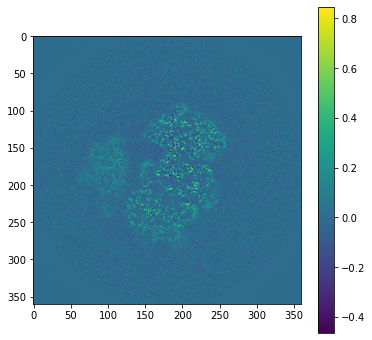

In [164]:
plt.imshow(og_v[0,180]); plt.colorbar()

In [165]:
logger.info(f"Downsampling to {(img_size,)*3}")
v = og_v.downsample(img_size)
L = v.resolution

2022-06-20 18:41:06,818 INFO Downsampling to (32, 32, 32)


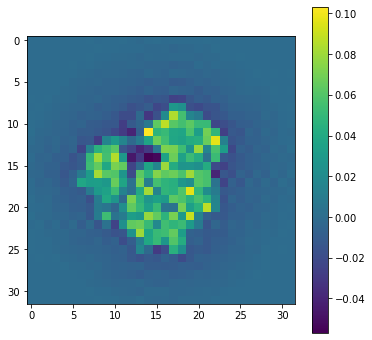

In [166]:
plt.imshow(v[0,16]); plt.colorbar()

In [167]:
if save_to_file:
    with mrcfile.new(out_dir + '/og_v.mrc', overwrite=True) as mrc:
        mrc.set_data(og_v._data.astype(np.float32))

In [168]:
if save_to_file:
    with mrcfile.new(out_dir + '/og_v_downsampled.mrc', overwrite=True) as mrc:
        mrc.set_data(v._data.astype(np.float32))

In [169]:
# Then create a filter based on that variance
# This is an example of a custom noise profile
def noise_function(x, y):
    alpha = 1
    beta = 1
    # White
    f1 = noise_variance
    # Violet-ish
    f2 = noise_variance * (x * x + y * y) / L * L
    return (alpha * f1 + beta * f2) / 2.0


custom_noise_filter = FunctionFilter(noise_function)

In [170]:
logger.info("Initialize CTF filters.")
# Create some CTF effects
pixel_size = 5 * 65 / img_size  # Pixel size of the images (in angstroms)
voltage = 200  # Voltage (in KV)
defocus_min = 1.5e4  # Minimum defocus value (in angstroms)
defocus_max = 2.5e4  # Maximum defocus value (in angstroms)
defocus_ct = 7  # Number of defocus groups.
Cs = 2.0  # Spherical aberration
alpha = 0.1  # Amplitude contrast

# Create filters
ctf_filters = [
    RadialCTFFilter(pixel_size, voltage, defocus=d, Cs=2.0, alpha=0.1)
    for d in np.linspace(defocus_min, defocus_max, defocus_ct)
]



2022-06-20 18:41:08,379 INFO Initialize CTF filters.


2022-06-20 18:41:11,885 INFO Creating Simulation with 1000 images.
2022-06-20 18:41:11,887 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-20 18:41:11,902 INFO Creating Simulation with 1000 images.
2022-06-20 18:41:11,903 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-20 18:41:11,915 INFO Appending a NoiseAdder to generation pipeline
2022-06-20 18:41:11,917 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-20 18:41:11,919 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-20 18:41:11,987 INFO Applying forward transformations in pipeline
2022-06-20 18:41:11,987 INFO All forward transformations applied
2022-06-20 18:41:11,987 INFO Loaded 10 images


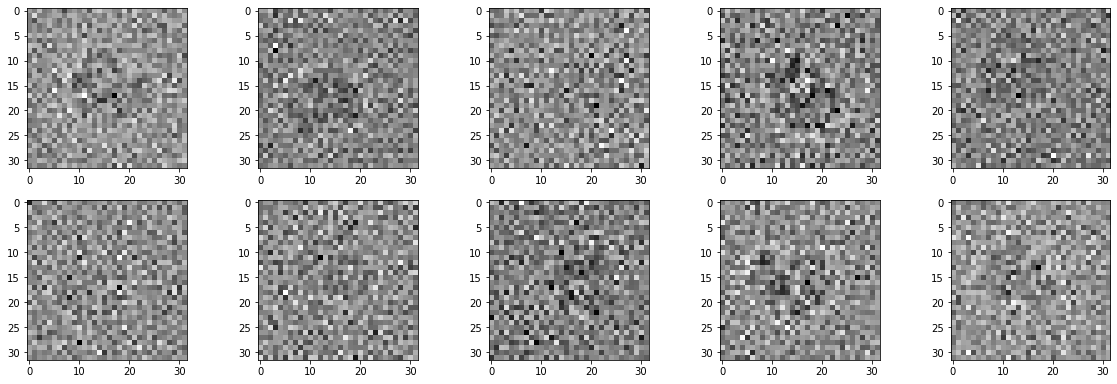

In [171]:
# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    noise_filter= None, #custom_noise_filter,
    unique_filters= None, #ctf_filters,
)

angles = src.angles
shifts = src.offsets

angles[0] = [0,0,0]
shifts[0] = [0,0]

# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    angles = angles,
    offsets = shifts,
    noise_filter= custom_noise_filter,
    unique_filters= ctf_filters,
)
# Peek
if interactive:
    src.images(0, 10).show()

In [172]:
# Use phase_flip to attempt correcting for CTF.
logger.info("Perform phase flip to input images.")
#src.phase_flip()


2022-06-20 18:41:26,448 INFO Perform phase flip to input images.


In [173]:
# Estimate the noise and `Whiten` based on the estimated noise
aiso_noise_estimator = AnisotropicNoiseEstimator(src)
#src.whiten(aiso_noise_estimator.filter)

2022-06-20 18:41:28,251 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-20 18:41:28,257 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-20 18:41:29,920 INFO Applying forward transformations in pipeline
2022-06-20 18:41:29,921 INFO All forward transformations applied
2022-06-20 18:41:29,921 INFO Loaded 512 images
2022-06-20 18:41:29,930 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-20 18:41:29,934 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-20 18:41:31,504 INFO Applying forward transformations in pipeline
2022-06-20 18:41:31,504 INFO All forward transformations applied
2022-06-20 18:41:31,505 INFO Loaded 488 images


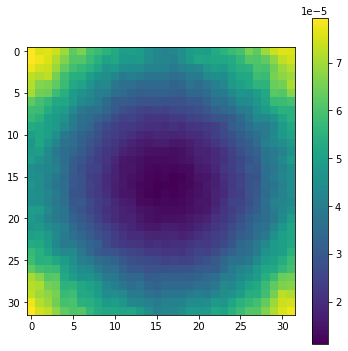

2022-06-20 18:41:53,609 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-20 18:41:53,610 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-20 18:41:53,673 INFO Applying forward transformations in pipeline
2022-06-20 18:41:53,674 INFO All forward transformations applied
2022-06-20 18:41:53,674 INFO Loaded 10 images


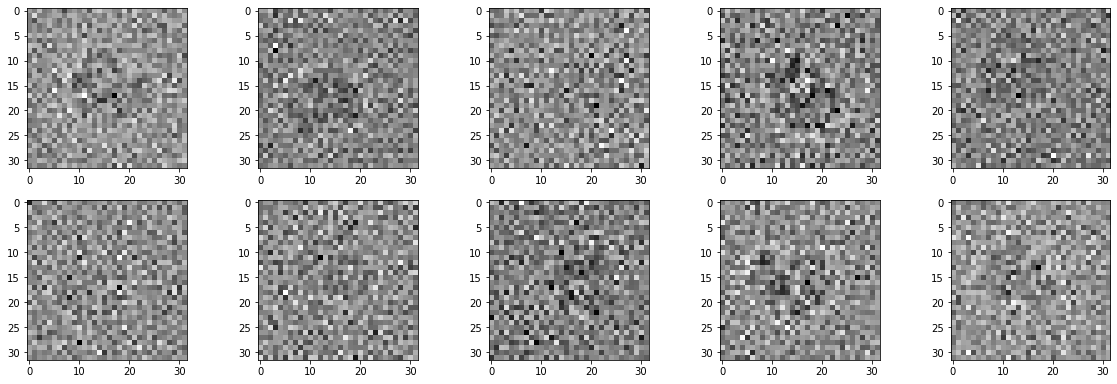

In [175]:
# Plot the noise profile for inspection
if interactive:
    plt.imshow(aiso_noise_estimator.filter.evaluate_grid(L))
    plt.colorbar()
    plt.show()

# Peek, what do the whitened images look like...
if interactive:
    src.images(0, 10).show()

In [176]:
# Cache to memory for some speedup
src.cache()

2022-06-20 18:42:02,043 INFO Caching source images
2022-06-20 18:42:02,045 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-20 18:42:02,055 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-20 18:42:05,223 INFO Applying forward transformations in pipeline
2022-06-20 18:42:05,224 INFO All forward transformations applied
2022-06-20 18:42:05,224 INFO Loaded 1000 images


### Class Averaging

In [ ]:
logging.disable(logging.INFO)

In [ ]:
logger.info("Begin Class Averaging")

rir = RIRClass2D(
    src,  # Source used for classification
    fspca_components=400,
    bispectrum_components=300,  # Compressed Features after last PCA stage.
    n_nbor=n_nbor,
    n_classes=n_classes,
    large_pca_implementation="legacy",
    nn_implementation="sklearn",
    bispectrum_implementation="legacy",
    averager=None,
)

classes, reflections, distances = rir.classify()
avgs = rir.averages(classes, reflections, distances)
if interactive:
    avgs.images(0, 10).show()

### Common Line Estimation

In [ ]:
logger.info("Begin Orientation Estimation")

# Stash true rotations for later comparison,
#   note this line only works with naive class selection...
true_rotations = src.rots[:n_classes]

orient_est = CLSyncVoting(avgs, n_theta=36)
# Get the estimated rotations
orient_est.estimate_rotations()
rots_est = orient_est.rotations

logger.info("Compare with known rotations")
# Compare with known true rotations
Q_mat, flag = register_rotations(rots_est, true_rotations)
regrot = get_aligned_rotations(rots_est, Q_mat, flag)
mse_reg = get_rots_mse(regrot, true_rotations)
logger.info(
    f"MSE deviation of the estimated rotations using register_rotations : {mse_reg}\n"
)

### Volume reconstruction

In [ ]:
logger.info("Begin Volume reconstruction")

# Assign the estimated rotations to the class averages
avgs.rots = rots_est

# Create a reasonable Basis for the 3d Volume
basis = FFBBasis3D((v.resolution,) * 3, dtype=v.dtype)

# Setup an estimator to perform the back projection.
estimator = MeanEstimator(avgs, basis)

# Perform the estimation and save the volume.
estimated_volume = estimator.estimate()
fn = f"{out_dir}/estimated_volume_n{num_imgs}_c{n_classes}_m{n_nbor}_{img_size}.mrc"
estimated_volume.save(fn, overwrite=True)

# Peek at result
if interactive:
    plt.imshow(np.sum(estimated_volume[0], axis=-1))
    plt.show()

In [ ]:
if save_to_file:
    with mrcfile.new(out_dir + '/rec_aspire.mrc', overwrite=True) as mrc:
        mrc.set_data(estimated_volume._data.astype(np.float32))

### Aspire vs JaxEM

Text(0.5, 1.0, 'Volume_comp MIP')

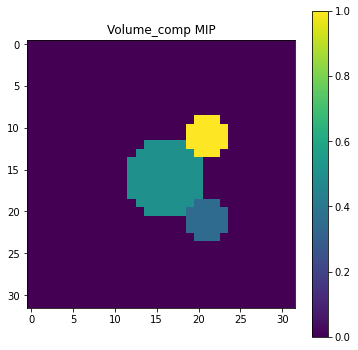

In [177]:
nx = img_size
shape = np.array([nx,nx,nx])
dimensions = pixel_size * shape

# A volume with components
centres = np.array([[0,0,0], [0.1, 0.1, 0], [0.1, -0.1, 0]]) * 500
radii = np.array([0.1, 0.05, 0.05]) * 500
intensities = np.array([10,7,20])

myv = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False, sigma = 0.1))
mip_z(myv)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

### Compare for specific angles/shifts/ctf_params 

In [178]:
angles = np.array(angles)
shifts = np.array(shifts)

angles[0] = [jnp.pi/6,jnp.pi/4, jnp.pi/2]
shifts[0] = [-5.4, 6.8]

#v._data = np.array([myv])

# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    angles = angles,
    offsets = shifts,
    noise_filter= custom_noise_filter,
    unique_filters= ctf_filters,
)
src.phase_flip()


N = 1
nx = img_size

vol = jnp.array(v._data[0])
vol_f, x_grid, _ = volume_fourier(v._data[0], pixel_size)
imgs = jnp.array(src.images(0,N).data)
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs])
angles = src.angles # "_rlnAngleRot", "_rlnAngleTilt", "_rlnAnglePsi" in radians -> I store psi, tilt,rot
shifts = src.offsets

print(f"x_grid = {x_grid}")

2022-06-20 18:42:06,891 INFO Creating Simulation with 1000 images.
2022-06-20 18:42:06,893 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-20 18:42:06,910 INFO Appending a NoiseAdder to generation pipeline
2022-06-20 18:42:06,911 INFO Perform phase flip on source object
2022-06-20 18:42:06,912 INFO Adding Phase Flip Xform to end of generation pipeline
2022-06-20 18:42:06,918 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-20 18:42:06,920 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-20 18:42:06,945 INFO Applying forward transformations in pipeline
2022-06-20 18:42:06,946 INFO   Applying IndexedXform
2022-06-20 18:42:06,949 INFO All forward transformations applied
2022-06-20 18:42:06,949 INFO Loaded 1 images
x_grid = [3.07692308e-03 3.20000000e+01]


In [179]:
angles[0]

array([0.5235988, 0.7853982, 1.5707964], dtype=float32)

In [180]:
myshifts = jnp.array([shifts[0,1], shifts[0,0]]) * pixel_size # This seems correct
myangles = -jnp.array([angles[0,2], angles[0,1], angles[0,0]])
myctf_params = jnp.array(
    [jnp.array([f.defocus_u, f.defocus_v, f.defocus_ang, 0, f.voltage, f.alpha, f.Cs, 0, 2*pixel_size]) for f in ctf_filters]
)[0]

Text(0.5, 1.0, 'my projection')

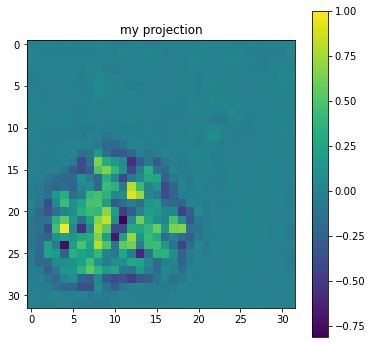

In [181]:
pr = project_spatial(vol, myangles, pixel_size, myshifts, ctf_params= myctf_params)
pr = pr/jnp.max(pr)
plt.imshow(pr); plt.colorbar()
plt.title('my projection')

Text(0.5, 1.0, 'aspire')

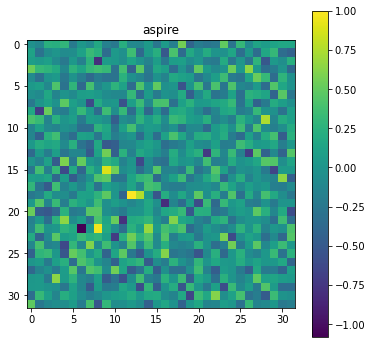

In [182]:
pr_a = imgs[0] /jnp.max(imgs[0])
plt.imshow(pr_a); plt.colorbar()
plt.title('aspire')

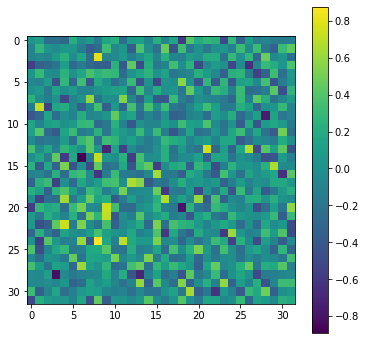

In [183]:
plt.imshow(pr-pr_a); plt.colorbar()

### Compare for many images

In [184]:
def get_params_from_aspire(src: Simulation, N, pixel_size):
    
    imgs = np.array(src.images(0,N).data)
    imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs])
    
    angles = src.angles # "_rlnAngleRot", "_rlnAngleTilt", "_rlnAnglePsi" in radians -> I store psi, tilt,rot
    shifts = src.offsets
    
    myshifts = jnp.flip(shifts, axis=1) * pixel_size 
    myangles = -jnp.flip(angles, axis=1)
    
    cf = src.unique_filters
    myctf_params = jnp.array(
        [jnp.array([cf[ci].defocus_u, cf[ci].defocus_v, cf[ci].defocus_ang, 0, cf[ci].voltage, cf[ci].alpha, cf[ci].Cs, 0, 2*pixel_size]) for ci in src.filter_indices]
    )
    
    return imgs, imgs_f, myangles, myshifts, myctf_params

@jax.jit
def calc_img_err(img1, img2, mask):
    img1 = jnp.fft.fftshift(img1*mask)
    img1 = img1/jnp.max(jnp.abs(img1))
    
    img2 = jnp.fft.fftshift(img2*mask)
    img2 = img2/jnp.max(jnp.abs(img2))
    
    return jnp.mean(jnp.abs(img1-img2))

calc_img_err_vmap = jax.vmap(calc_img_err, in_axes = (0,0,None))

In [185]:
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    noise_filter= None, #custom_noise_filter,
    unique_filters= ctf_filters,
)
src.phase_flip()

vol = jnp.array(v._data[0])
vol_f, x_grid, _ = volume_fourier(v._data[0], pixel_size)

N = num_imgs
nx = img_size
alpha = 1e-6

radius = x_grid[0]*(x_grid[1]/2-1)
mask = create_2d_mask(x_grid, [0,0], radius)

slice_obj = Slice(x_grid, mask)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

2022-06-20 18:42:14,968 INFO Creating Simulation with 1000 images.
2022-06-20 18:42:14,970 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-20 18:42:14,985 INFO Perform phase flip on source object
2022-06-20 18:42:14,986 INFO Adding Phase Flip Xform to end of generation pipeline


In [186]:
imgs_aspire, imgs_f_aspire, angles, shifts, ctf_params = get_params_from_aspire(src, 1000, pixel_size)
imgs_f = slice_obj.slice_array(vol_f, angles, shifts, ctf_params).reshape([-1, nx,nx])

2022-06-20 18:42:16,066 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-20 18:42:16,074 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-20 18:42:16,485 INFO Applying forward transformations in pipeline
2022-06-20 18:42:16,487 INFO   Applying IndexedXform
2022-06-20 18:42:16,522 INFO All forward transformations applied
2022-06-20 18:42:16,523 INFO Loaded 1000 images


In [187]:
errs = calc_img_err_vmap(imgs_f, imgs_f_aspire, mask)
print(f"errs.shape = {errs.shape}")
print(f"jnp.max(errs) = {jnp.max(errs)}")

errs.shape = (1000,)
jnp.max(errs) = 0.05482021331179919


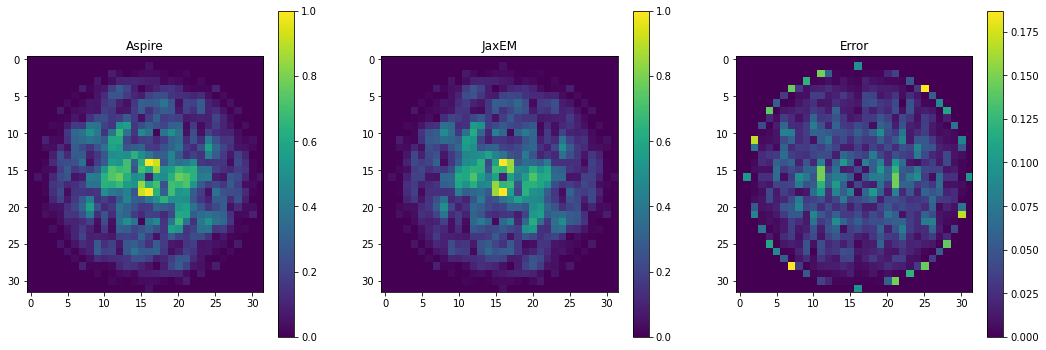

In [188]:
imgidx = 13

img1 = jnp.fft.fftshift(imgs_f_aspire[imgidx]*mask)
img1 = img1/jnp.max(jnp.abs(img1))

img2 = jnp.fft.fftshift(imgs_f[imgidx]*mask)
img2 = img2/jnp.max(jnp.abs(img2))

err_f = jnp.abs(img1-img2)

plt.rcParams["figure.figsize"]=18,6

plt.subplot(1,3,1)
plt.imshow(jnp.abs(img1))
plt.colorbar()
plt.title("Aspire")

plt.subplot(1,3,2)
plt.imshow(jnp.abs(img2))
plt.colorbar()
plt.title("JaxEM")

plt.subplot(1,3,3)
plt.imshow(err_f)
plt.colorbar()
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

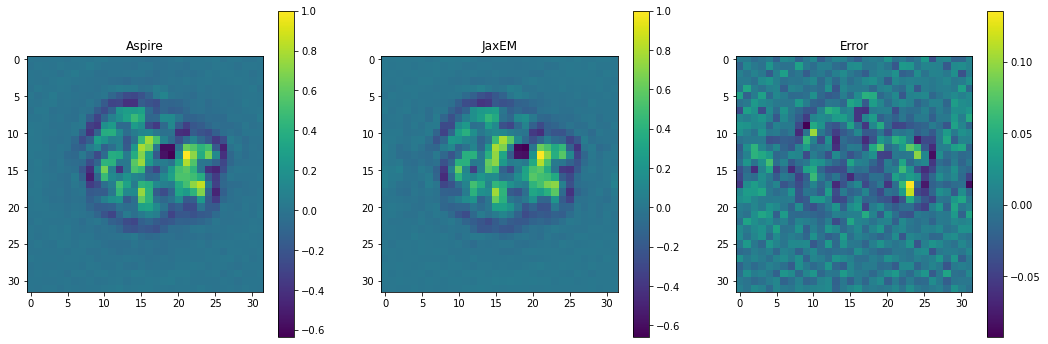

In [189]:
img1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifft2(imgs_f_aspire[imgidx]*mask)))
img1 = img1/jnp.max(img1)

img2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifft2(imgs_f[imgidx]*mask)))
img2 = img2/jnp.max(img2)

plt.rcParams["figure.figsize"]=18,6

plt.subplot(1,3,1)
plt.imshow(img1)
plt.colorbar()
plt.title("Aspire")

plt.subplot(1,3,2)
plt.imshow(img2)
plt.colorbar()
plt.title("JaxEM")

plt.subplot(1,3,3)
plt.imshow(img1-img2)
plt.colorbar()
plt.title("Error")

plt.rcParams["figure.figsize"]=6,6

### Next: noise-free volume reconstruction with SGD, then make sure the noise estimation is consistent and do noisy reconstruction.

2022-06-20 18:42:25,073 INFO Creating Simulation with 1000 images.
2022-06-20 18:42:25,075 WARNING Simulation vols.dtype float64 != self.dtype float32. In the future this will raise an error.
2022-06-20 18:42:25,089 INFO Appending a NoiseAdder to generation pipeline
2022-06-20 18:42:25,090 INFO Perform phase flip on source object
2022-06-20 18:42:25,091 INFO Adding Phase Flip Xform to end of generation pipeline
2022-06-20 18:42:25,096 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-20 18:42:25,105 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-20 18:42:28,294 INFO Applying forward transformations in pipeline
2022-06-20 18:42:28,295 INFO   Applying IndexedXform
2022-06-20 18:42:28,328 INFO All forward transformations applied
2022-06-20 18:42:28,328 INFO Loaded 1000 images
2022-06-20 18:42:28,671 WARNING Volume rot_matrices.dtype float32 != self.dtype float6

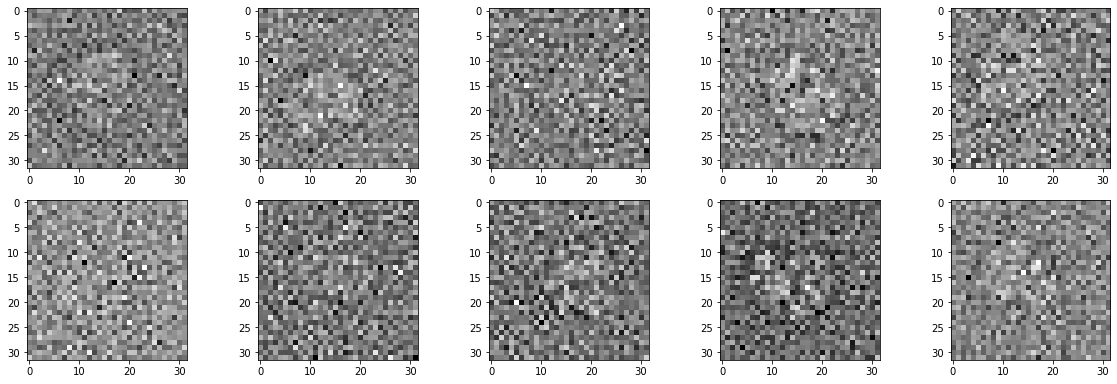

In [190]:
N = num_imgs
nx = img_size

src = Simulation(
    L=v.resolution,
    n=N,
    vols=v,
    noise_filter=custom_noise_filter,
    unique_filters=ctf_filters,
)
src.phase_flip()

imgs_aspire, imgs_f_aspire, angles, shifts, ctf_params = get_params_from_aspire(src, N, pixel_size)

src.images(0, 10).show()

2022-06-20 18:42:43,458 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-20 18:42:43,463 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-20 18:42:45,150 INFO Applying forward transformations in pipeline
2022-06-20 18:42:45,151 INFO   Applying IndexedXform
2022-06-20 18:42:45,174 INFO All forward transformations applied
2022-06-20 18:42:45,175 INFO Loaded 512 images
2022-06-20 18:42:45,182 WARNING Volume rot_matrices.dtype float32 != self.dtype float64. In the future this will raise an error.
2022-06-20 18:42:45,185 WARNING nufft passed inconsistent dtypes. fourier_pts: float32 forcing precision of signal data: float64.
2022-06-20 18:42:46,738 INFO Applying forward transformations in pipeline
2022-06-20 18:42:46,739 INFO   Applying IndexedXform
2022-06-20 18:42:46,762 INFO All forward transformations applied
2022-06-20 18:42:46,763 INFO Loaded 488 images


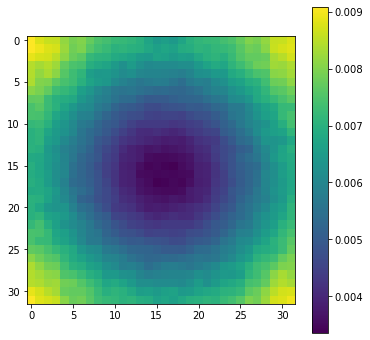

In [192]:
aiso_noise_estimator = AnisotropicNoiseEstimator(src)
sigma_noise = jnp.sqrt(aiso_noise_estimator.filter.evaluate_grid(L))

plt.imshow(sigma_noise)
plt.colorbar()

In [193]:
jnp.max(sigma_noise)

DeviceArray(0.00908968, dtype=float64)

In [201]:
vol = jnp.array(v._data[0])
vol_f, x_grid, _ = volume_fourier(v._data[0], pixel_size)

alpha = 1e-3

radius = x_grid[0]*(x_grid[1]/2-1)
mask = create_2d_mask(x_grid, [0,0], radius)

slice_obj = Slice(x_grid, mask)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

In [203]:
N_epochs = 300
batch_size = 100
step_size = 1e-5
grad_func = get_sgd_vol_ops(gradv_obj, angles, shifts, ctf_params, imgs_f_aspire.reshape(N,-1), sigma_noise.reshape(-1))
x0 = jnp.zeros([nx,nx,nx], dtype=jnp.complex128)

x = sgd(grad_func, N, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=10)

  sgd epoch 0: mean gradient = 1.5021268247680495
  sgd epoch 10: mean gradient = 0.7572341160787215
  sgd epoch 20: mean gradient = 0.35822101305731324
  sgd epoch 30: mean gradient = 0.0959680432548828
  sgd epoch 40: mean gradient = 0.4128433285820781
  sgd epoch 50: mean gradient = 0.5115181739158671
  sgd epoch 60: mean gradient = 0.25447713194071214
  sgd epoch 70: mean gradient = 0.035898726120680104
  sgd epoch 80: mean gradient = 0.09095340115531297
  sgd epoch 90: mean gradient = 0.09164480132801152
  sgd epoch 100: mean gradient = 0.3800796379893228
  sgd epoch 110: mean gradient = 0.0842322751410529
  sgd epoch 120: mean gradient = 0.024413675366478912
  sgd epoch 130: mean gradient = 0.022181327705335395
  sgd epoch 140: mean gradient = 0.31345297953008383
  sgd epoch 150: mean gradient = 0.17243823641512385
  sgd epoch 160: mean gradient = 0.31889439018591953
  sgd epoch 170: mean gradient = 0.10271873758174067
  sgd epoch 180: mean gradient = 0.056086009399936104
  sgd e

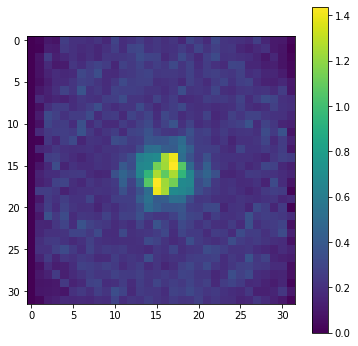

In [204]:
mip_z(jnp.fft.fftshift(jnp.abs(x))); plt.colorbar()

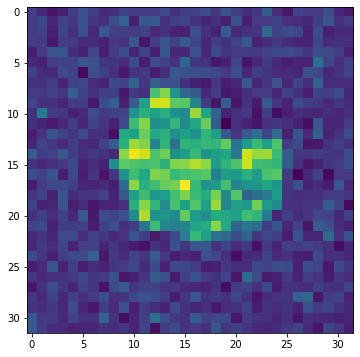

In [205]:
vol_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(x)))
mip_z(vol_rec)

In [206]:
if save_to_file:
    with mrcfile.new(out_dir + '/rec_sgd_noise.mrc', overwrite=True) as mrc:
        mrc.set_data(vol_rec.astype(np.float32))

### TODO

* Tidy up the SGD reconstruction section of the notebook and make it self contained
* Make sure that $\sigma_{noise}$ is estimated correctly
* Compare with reconstruction with wrong $\sigma_{noise}$ to make sure it makes sense
* play with different parameter values: step size, regularization parameter